# MNISTデータセット

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

In [2]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()


Using TensorFlow backend.


## データセットの確認

In [3]:
print(X_train.shape) # (60000, 28, 28)
print(X_test.shape) # (10000, 28, 28)
print(X_train[0].dtype) # uint8
print(X_train[0])

(60000, 28, 28)
(10000, 28, 28)
uint8
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   3  18  18  18 126 136
  175  26 166 255 247 127   0   0   0   0]
 [  0   0   0   0   0   0   0   0  30  36  94 154 170 253 253 253 253 253
  225 172 253 242 195  64   0   0   0   0]
 [  0   0   0   0   0   0   0  49 238 253 253 253 253 253 253 253 253 251
   93  82  82  56  39   0   0   0   0   0]
 [  0   0   0   0   0   0 

## 平滑化

In [4]:
X_train = X_train.reshape(-1, 784)
X_test = X_test.reshape(-1, 784)

X_train.shape
X_test.shape


(10000, 784)

## 画像データの可視化

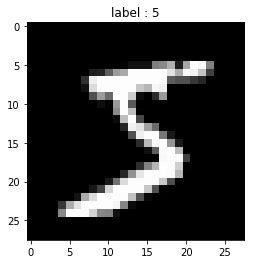

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
index = 0
image = X_train[index].reshape(28,28)
# X_train[index]: (784,)
# image: (28, 28)
plt.imshow(image, 'gray')
plt.title('label : {}'.format(y_train[index]))
plt.show()

## 前処理


In [6]:
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255
print(X_train.max()) # 1.0
print(X_train.min()) # 0.0

1.0
0.0


In [7]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])
print(y_train.shape) # (60000,)
print(y_train_one_hot.shape) # (60000, 10)
print(y_train_one_hot.dtype) # float64

(60000,)
(60000, 10)
float64


In [8]:
X_train_, X_val, y_train_, y_val = train_test_split(X_train, y_train_one_hot, test_size=0.2)
print("X_train.shape =", X_train_.shape)
print("X_val.shape =", X_val.shape)
print("y_train.shape =", y_train_.shape)
print("y_val.shape =", y_val.shape)

X_train.shape = (48000, 784)
X_val.shape = (12000, 784)
y_train.shape = (48000, 10)
y_val.shape = (12000, 10)


# ニューラルネットワークスクラッチ

In [9]:
class ScratchSimpleNeuralNetrowkClassifier():
    """
    シンプルな三層ニューラルネットワーク分類器

    Parameters
    ----------
    num_iter : int
      イテレーション数
    lr : float
      学習率
    no_bias : bool
      バイアス項を入れない場合はTrue
    verbose : bool
      学習過程を出力する場合はTrue

    Attributes
    ----------
    self.loss : 次の形のndarray, shape (self.iter,)
      学習用データに対する損失の記録
    self.val_loss : 次の形のndarray, shape (self.iter,)
      検証用データに対する損失の記録
    """

    def __init__(self, num_epoch = 10,lr = 0.01,batch_size = 20, n_features = 784, n_nodes1 = 400, n_nodes2 = 200, n_output = 10, verbose = False):
        self.num_epoch = num_epoch
        self.lr = lr
        self.verbose = verbose
        
        self.batch_size = batch_size
        self.n_features = n_features
        self.n_nodes1 = n_nodes1
        self.n_nodes2 = n_nodes2
        self.n_output = n_output
        
        self.W1 = None
        self.W2 = None
        self.W3 = None
        self.A1 = None
        self.A2 = None
        self.A3 = None
        self.Z1 = None
        self.Z2 = None
        self.Z3 = None
        
        
    def sigmoid(self):
        """
        シグモイド関数の計算

        """
        return 1 / (1 + np.exp(- self.A1))
    
    def softmax(self):
        """
        Z3k: k番目のクラスの確率ベクトル (batch_size,)
        A3k: k番目のクラスにあたる前の層からのベクトル (batch_size,)
        nc : クラスの数、n_output。今回のMNISTでは10。
        """
        self.Z3 = np.exp(self.A3) / np.reshape(np.sum(np.exp(self.A3), axis=1),(-1,1))

        return self.Z3
    
    def get_WB(self,n_features, n_nodes):
        self.sigma = 0.01
        WB = self.sigma * np.random.randn(n_features, n_nodes)
        
        return WB
            
    def forwardpropagation(self,X):
        """
        X : 特徴量ベクトル (batch_size, n_features)
        W1 : 1層目の重み (n_features, n_nodes1)
        B1: 1層目のバイアス (n_nodes1,)
        A1: 出力 (batch_size, n_nodes1)
        """
        self.A1 = X@self.W1 + self.B1     

        """
        f(): 活性化関数
        Z1出力 (batch_size, n_nodes1)
        """
        self.Z1 = np.tanh(self.A1) 

        """
        W2: 2層目の重み (n_nodes1, n_nodes2)
        B2: 2層目のバイアス (n_nodes2,)
        A2: 出力 (batch_size, n_nodes2)
        """
        self.A2 =self. Z1@self.W2 + self.B2

        """
        f(): 活性化関数
        Z2出力 (batch_size, n_nodes2)
        """
        self.Z2 = np.tanh(self.A2)

        """
        W3: 3層目の重み (n_nodes2, n_output)
        B3: 3層目のバイアス (n_output,)
        A3: 出力 (batch_size, n_output)
        """
        self.A3 = self.Z2@self.W3 + self.B3

        """
        softmax(): ソフトマックス関数
        Z3出力 (batch_size, n_output)
        Z3 は各ラベル（0〜9）に対する確率の配列である。
        """
        self.Z3 = self.softmax()
        
        return self.Z3
    
    def cross_entropy_error(self,y):
        """
        交差エントロピー誤差の計算
        """
        if y.ndim == 1:
            y = np.reshape(y, (-1,1))
        
        self.L = -1 * (np.mean(np.sum(y*np.log(self.Z3),axis=1),axis =0 ))
    
    def backpropagation(self, X, y):

        #3層目
        L_A3 = self.Z3 - y
        L_B3 = np.sum(L_A3,axis=0)
        L_W3 = (self.Z2).T@L_A3
        L_Z2 = L_A3@self. W3.T
        
        
        #2層目
        L_A2 = L_Z2 * (1 - (np.tanh(self.A2))**2)
        L_B2 = np.sum(L_A2, axis=0)
        L_W2 = self.Z1.T@L_A2
        L_Z1 = L_A2@self.W2.T
        
        
        #1層目
        L_A1 = L_Z1*(1 - (np.tanh(self.A1)**2))
        L_B1 = np.sum(L_A1, axis=0)
        L_W1 = (X.T)@L_A1
        
        #重み,バイアスの更新
        self.W1 = self.W1 - self.lr*L_W1
        self.W2 = self.W2 - self.lr*L_W2
        self.W3 = self.W3 - self.lr*L_W3

        self.B1 = self.B1 - self.lr*L_B1
        self.B2 = self.B2 - self.lr*L_B2
        self.B3 = self.B3 - self.lr*L_B3

        
    def fit(self, X, y, X_val=None, y_val=None):
        """
        ニューラルネットワーク分類器を学習する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練用データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練用データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証用データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証用データの正解値
        """
        exist_valdata = False
        if X_val is not None:
            exist_valdata = True
            
        #重み、バイアスの初期化
        self.W1 = self.get_WB(self.n_features, self.n_nodes1)
        self.W2 = self.get_WB(self.n_nodes1, self.n_nodes2)
        self.W3 = self.get_WB(self.n_nodes2, self.n_output)
        self.B1  = self.sigma* np.random.randn(400)
        self.B2  = self.sigma* np.random.randn(200)
        self.B3  = self.sigma* np.random.randn(10)

        self.loss_list = []
        self.val_loss = []
        for i in range(self.num_epoch):            
            get_mini_batch = GetMiniBatch(X, y, batch_size=20)
            for mini_X_train, mini_y_train in get_mini_batch:

                self.forwardpropagation(mini_X_train)
                self.cross_entropy_error(mini_y_train)
                self.backpropagation(mini_X_train, mini_y_train)
            
            self.loss_list.append(self.L)
            
        if exist_valdata:
            #重み、バイアスの初期化
            self.W1 = self.get_WB(self.n_features, self.n_nodes1)
            self.W2 = self.get_WB(self.n_nodes1, self.n_nodes2)
            self.W3 = self.get_WB(self.n_nodes2, self.n_output)
            self.B1  = self.sigma* np.random.randn(400)
            self.B2  = self.sigma* np.random.randn(200)
            self.B3  = self.sigma* np.random.randn(10)
            
            for i in range(self.num_epoch):            
            
                get_mini_batch = GetMiniBatch(X_val, y_val, batch_size=20)
                for mini_X_val, mini_y_val in get_mini_batch:

                    self.forwardpropagation(mini_X_val)
                    self.cross_entropy_error(mini_y_val)
                    self.backpropagation(mini_X_val, mini_y_val)

                self.val_loss.append(self.L)


        if self.verbose:
            print(self.loss_list)
        
    def predict(self, X):
        """
        ニューラルネットワーク分類器を使い推定する。

        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル

        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            推定結果
        """
        return np.argmax(self.forwardpropagation(X), axis=1)
        



## ミニバッチ処理

In [10]:
class GetMiniBatch:
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練用データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)

    def __len__(self):
        return self._stop

    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        

    def __iter__(self):
        self._counter = 0
        return self

    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]
    


## 【問題1】重みの初期値を決めるコードの作成


In [11]:
n_features = 784
n_nodes1 = 400
sigma = 0.01 # ガウス分布の標準偏差
W1 = sigma * np.random.randn(n_features, n_nodes1)
# W1: (784, 400)


## 【問題2】フォワードプロパゲーションの実装


In [12]:
batch_size = 20 # バッチサイズ
n_features = 784 # 特徴量の数
n_nodes1 = 400 # 1層目のノード数
n_nodes2 = 200 # 2層目のノード数
n_output = 10 # 出力のクラス数（3層目のノード数）

def forwardpropagation():
    """
    X : 特徴量ベクトル (batch_size, n_features)
    W1 : 1層目の重み (n_features, n_nodes1)
    B1: 1層目のバイアス (n_nodes1,)
    A1: 出力 (batch_size, n_nodes1)
    """
    W1 = sigma * np.random.randn(n_features, n_nodes1)
    B1 = sigma * np.random.randn(n_nodes1,)
    A1 = X@W1 + B1

    """
    f(): 活性化関数
    Z1出力 (batch_size, n_nodes1)
    """
    Z1 = sigmoid(A1) 

    """
    W2: 2層目の重み (n_nodes1, n_nodes2)
    B2: 2層目のバイアス (n_nodes2,)
    A2: 出力 (batch_size, n_nodes2)
    """
    sigma = 0.01
    W2 = sigma * np.random.randn(n_nodes1, n_nodes2)
    B2 = sigma * np.random.randn(n_nodes1,)
    A2 = Z1@W2 + B2

    """
    f(): 活性化関数
    Z2出力 (batch_size, n_nodes2)
    """
    Z2 = sigmoid(A2)

    """
    W3: 3層目の重み (n_nodes2, n_output)
    B3: 3層目のバイアス (n_output,)
    A3: 出力 (batch_size, n_output)
    """
    B3 = sigma * np.random.randn(n_output,)
    W3 = sigma * np.random.randn(n_nodes2, n_output)
    A3 = Z2@W3 + B3

    """
    softmax(): ソフトマックス関数
    Z3出力 (batch_size, n_output)
    Z3 は各ラベル（0〜9）に対する確率の配列である。
    """
    Z3 = softmax(A3)
    
    return Z3

## 活性化関数（フォワードプロバゲーション）

In [13]:
def sigmoid(A1):
    """
    シグモイド関数の計算
    
    """
    return 1 / (1 + np.exp(- A1))

## ソフトマックス関数

In [14]:
def softmax(A3):
    """
    Z3k: k番目のクラスの確率ベクトル (batch_size,)
    A3k: k番目のクラスにあたる前の層からのベクトル (batch_size,)
    nc : クラスの数、n_output。今回のMNISTでは10。
    """
    Z3 = np.exp(A3) / np.sum(np.ezp(A3), axis=1)
    
    return Z3

## 【問題3】交差エントロピー誤差の実装

In [15]:
def cross_entropy_error(y) :
    """
    交差エントロピー誤差の計算
    """
    L = np.sum(np.sum(y*np.log(Z3),axis=1),axis =0 )/ - batch_size
    
    return L

## 【問題4】バックプロパゲーションの実装


In [16]:
def backpropagation(X, y):

    #更新式
    Wi = Wi - alpha * L_Wi
    Bi = Bi - alpha * L_Bi

    #3層目
    L_A3 = Z3 - y
    L_B3 = np.sum(L_A3,axis=0)
    L_W3 = Z2@L_A3
    L_Z2 = L_A3@ W3.T

    #2層目
    L_A2 = L_Z2 * (1 - (np.tanh(A2))**2)
    L_B2 = L_A2
    L_W2 = Z1*L_A2# アダマール積
    L_Z1 = L_A2@W2.T

    #1層目
    L_A1 = L_Z1*(1 - (np.tanh(A1)**2))
    L_B1 = L_A1
    L_W1 = (X.T) * L_A1#アダマール積

    return Wi, Bi

## 【問題5】推定


## 【問題6】学習と推定


In [17]:
nnc = ScratchSimpleNeuralNetrowkClassifier()

In [18]:
nnc.fit(X_train_, y_train_, X_val,y_val)

In [19]:
nnc.loss_list

[0.3287095524828171,
 0.09682748710486325,
 0.04051810172018944,
 0.030765283891592155,
 0.02963387861345739,
 0.02676669247359668,
 0.016789775665532143,
 0.018651264848688794,
 0.008251624276903038,
 0.0015837650804422186]

In [20]:
y = nnc.predict(X_test)

In [21]:
print(accuracy_score(y_test, y))

0.9536


## 【問題7】学習曲線のプロット

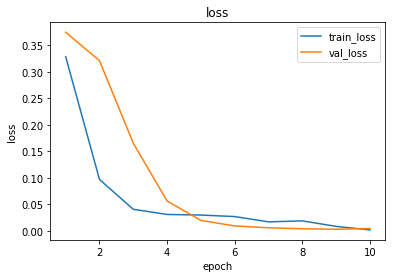

In [23]:
plt.title("loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.plot(np.arange(1, 10 + 1), nnc.loss_list, label="train_loss")
plt.plot(np.arange(1, 10 + 1), nnc.val_loss, label="val_loss")
plt.legend()
plt.show()